# Прогнозирование поведения клиента

#### Импортируем нужные библиотеки

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

#### Выгружаем данные с винтажами

In [4]:

df = pd.read_csv(
    "data_vintages.csv",
    sep=";",
    encoding="cp1251",
    index_col=0,
    parse_dates=["gen_month_dt", "gen_quarter_dt"],
)
df.head(10)

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336,19.0,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,35907,16.0,2019-04-01,2019-04-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,45228,21.0,2019-05-01,2019-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,39035,23.0,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,130780,19.0,2019-08-01,2019-07-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,13089,14.0,2019-03-01,2019-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,132017,7.0,2019-08-01,2019-07-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,67966,24.0,2019-06-01,2019-04-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,152759,11.0,2019-11-01,2019-10-01,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
9,128462,20.0,2019-08-01,2019-07-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [5]:
df_scores = pd.read_csv(
    "data_scores.csv", sep=";", encoding="cp1251", decimal=",", index_col=0
)

df_scores.head(10)

,user_id,pd,x_score
0,9311,0.035025,0.219980
1,155026,0.046279,0.146986
2,17584,0.007221,0.343298
3,156231,0.069679,0.186684
4,123587,0.010402,0.305582
5,125519,0.032667,0.261228
6,123890,0.027963,0.199389
7,82137,0.073694,0.113313
8,55227,0.011746,0.335474
9,124825,0.049237,0.227262


#### Бьем выборку на бакеты и джойним с данными с винтажами

In [6]:

df_scores = df_scores.sort_values(["pd"], ignore_index=True)
df_scores["pd_bucket"] = np.minimum(df_scores.index // (df_scores.shape[0] // 3), 2)
print(df_scores.groupby(["pd_bucket"])["pd"].mean())

df_scores = df_scores.sort_values(["x_score"], ignore_index=True)
df_scores["x_bucket"] = np.minimum(df_scores.index // (df_scores.shape[0] // 3), 2)
print(df_scores.groupby(["x_bucket"])["x_score"].mean())

df = df.merge(
    df_scores[["user_id", "pd_bucket", "x_bucket", "pd", "x_score"]],
    how="left",
    on="user_id",
).dropna()


df.head()

pd_bucket
0    0.011040
1    0.032685
2    0.068209
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score
0,127336,19.0,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,2,0.021296,0.469410
1,35907,16.0,2019-04-01,2019-04-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0,0.064742,0.157215
2,45228,21.0,2019-05-01,2019-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,2,0.018490,0.469583
3,39035,23.0,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.025882,0.210896
4,130780,19.0,2019-08-01,2019-07-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,0.024330,0.269492


## Кривые DLQ ratio

Рассмотрим долю счетов в просрочке 1-3 ко всем активным счетам (активными называем счета находящихся в просрочке 0-3)
### $$DLQ ratio_n = \frac{\#DLQ_n}{\#ACT_n}$$

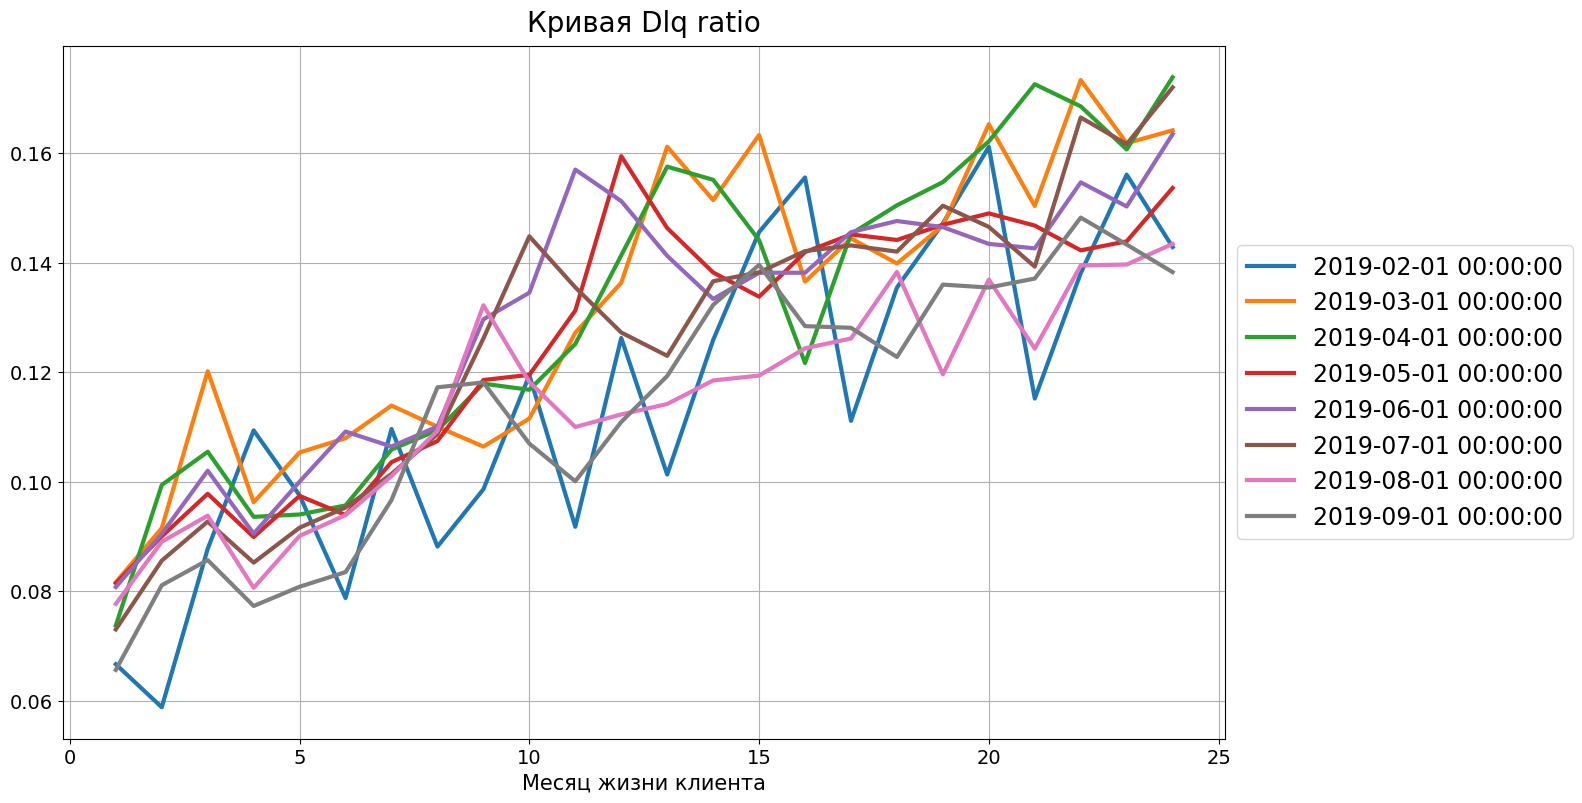

In [7]:
# DLQ ratio будем рассматривать по месяцам. Для удобства и наглядости возьмем только часть наблюдений
df = df[df["gen_month_dt"] < "2019-10-01"]


def plot_dlq_ratio_by_generation(df):
    return (
        df.groupby(["gen_month_dt", "statement_num"])
        .agg({"dlq_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})
        .rename(
            columns=({"dlq_flg": "dlq_cnt", "act_flg": "act_cnt", "user_id": "cnt"})
        )
        .eval("dlq_ratio = dlq_cnt / act_cnt", inplace=False)
        .unstack("gen_month_dt")["dlq_ratio"]
        .plot(ax=None, figsize=(15, 9), grid=True, lw=3)
    )


plot_dlq_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривая Dlq ratio", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

### Выберем параметр для разделения кривых

#### Разделение по PD

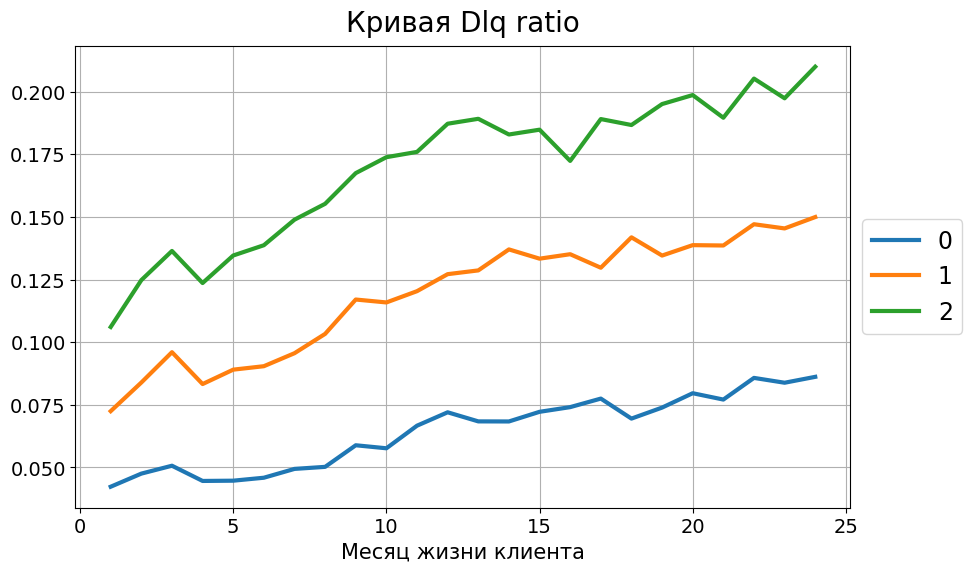

In [8]:
def plot_dlq_ratio_by_bucket(df, bucket):
    return (
        df.query(""" gen_month_dt != '2019-04-01' """)
        .groupby([bucket, "statement_num"])
        .agg({"dlq_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})
        .rename(
            columns=({"dlq_flg": "dlq_cnt", "act_flg": "act_cnt", "user_id": "cnt"})
        )
        .eval("dlq_ratio = dlq_cnt / act_cnt", inplace=False)
        .unstack(bucket)["dlq_ratio"]
        .plot(ax=None, figsize=(10, 6), grid=True, lw=3)
    )


plot_dlq_ratio_by_bucket(df, "pd_bucket")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривая Dlq ratio", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

#### Разделение по скору Х

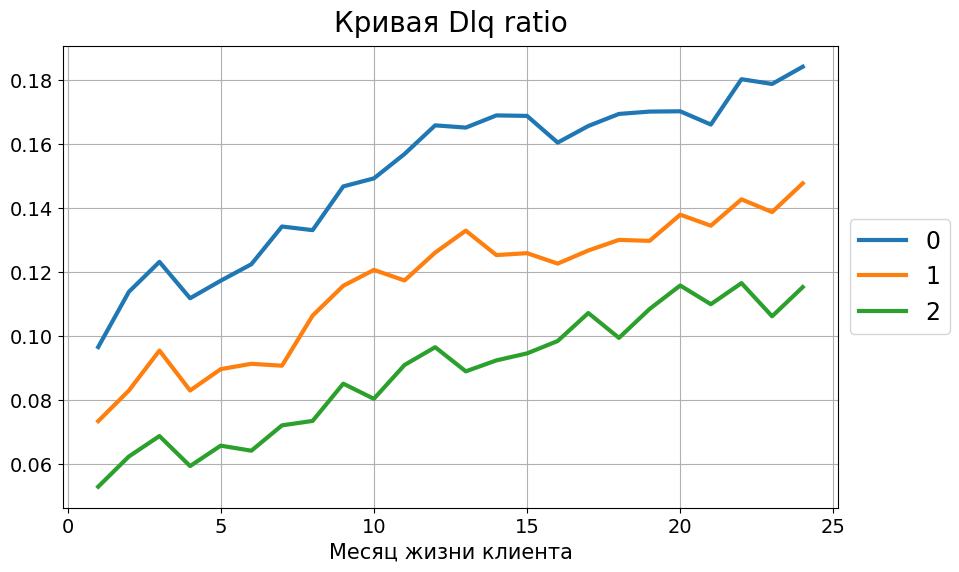

In [9]:
plot_dlq_ratio_by_bucket(df, "x_bucket")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривая Dlq ratio", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

#### При использовании PD кривые лежат дальше друг от друга, чем при использовании X_score, поэтому будем использовать PD

### Проверим выбору на странные поколения

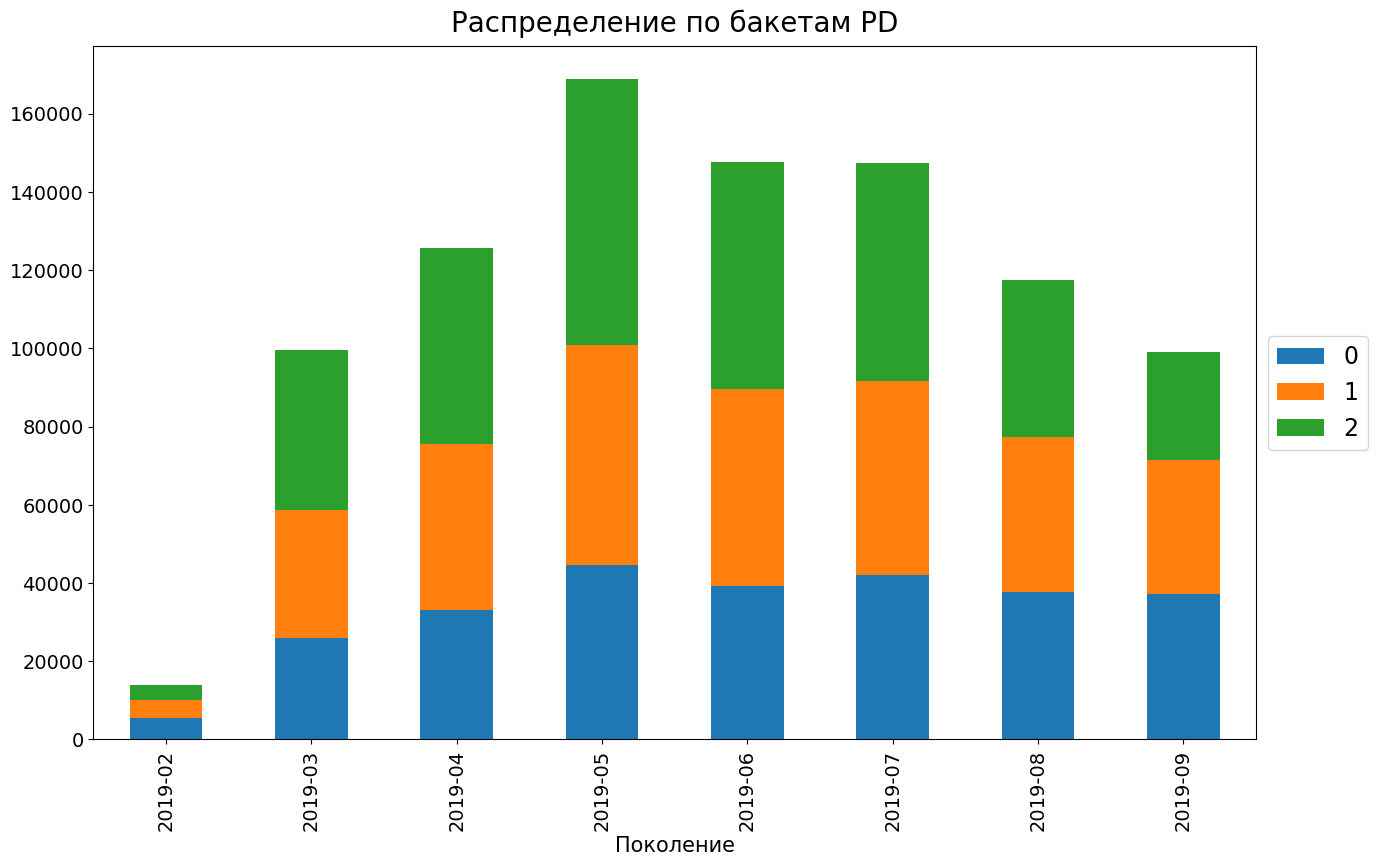

In [10]:
def plot_distribution(df, bucket):
    # Установить gen_month_dt как индекс
    df = df.set_index("gen_month_dt")

    # Теперь индекс — это DatetimeIndex, можно установить частоту
    df.index = df.index.to_period(freq="M")  # 'M' — ежемесячные данные

    return pd.pivot_table(
        df,
        index=[bucket],
        columns="gen_month_dt",  # делаем сводную таблицу и транспонируем ее
        values="user_id",
        aggfunc=np.count_nonzero,
        fill_value=0,
    ).T.plot(
        kind="bar", stacked=True, figsize=(15, 9)
    )  # Рисуем график распределения столбиками


plot_distribution(df, "pd_bucket")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Распределение по бакетам PD", size=20, verticalalignment="bottom")
plt.xlabel("Поколение", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

Во феврале 2019 года мало наблюдений (25000 на три бакета по 24 платежа), исключим это поколение из рассмотрения 

#### Рассмотрим поколения в разбивке по бакетам

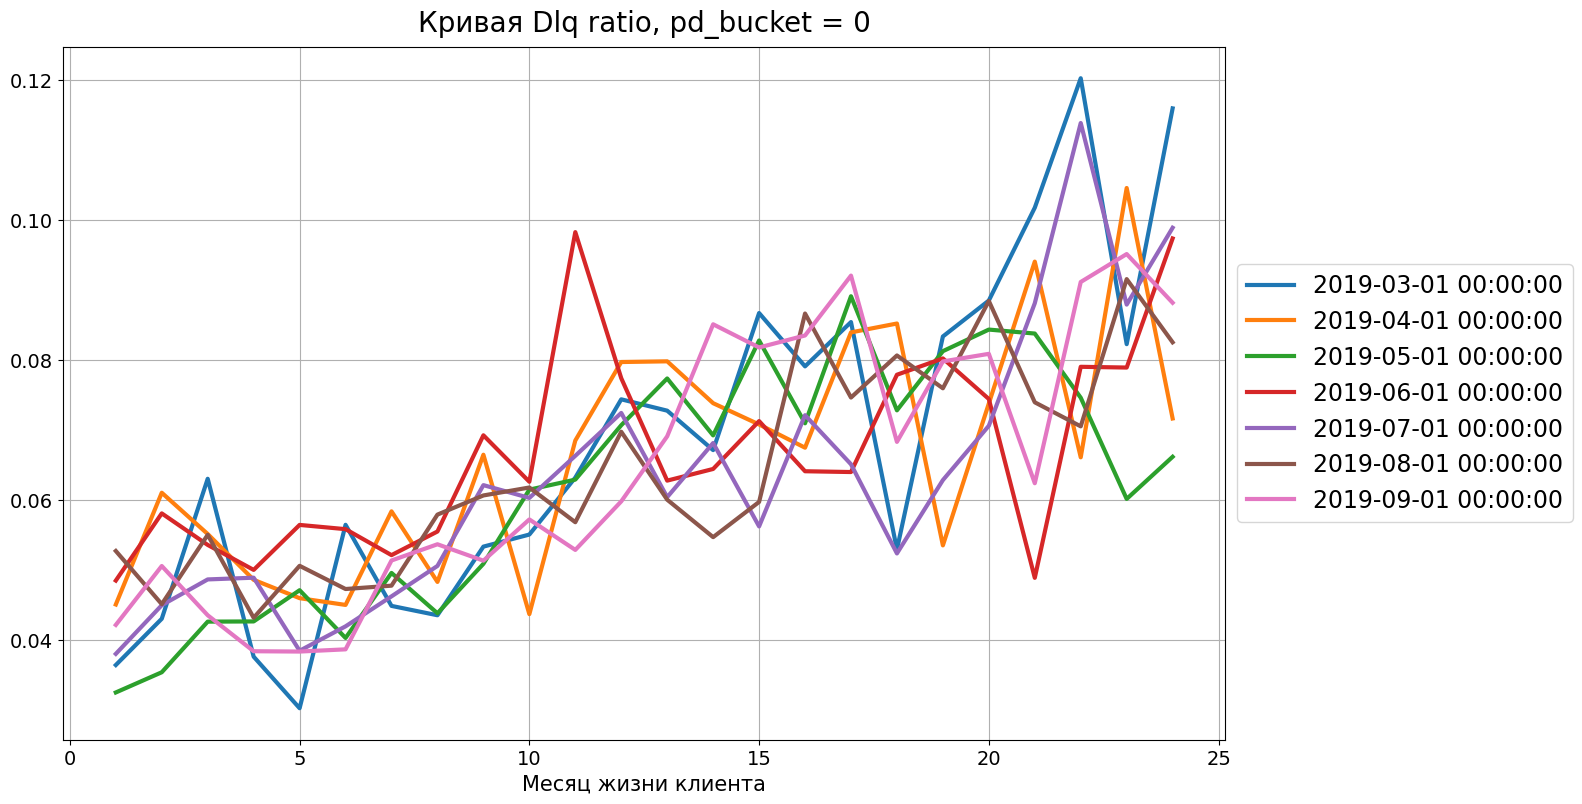

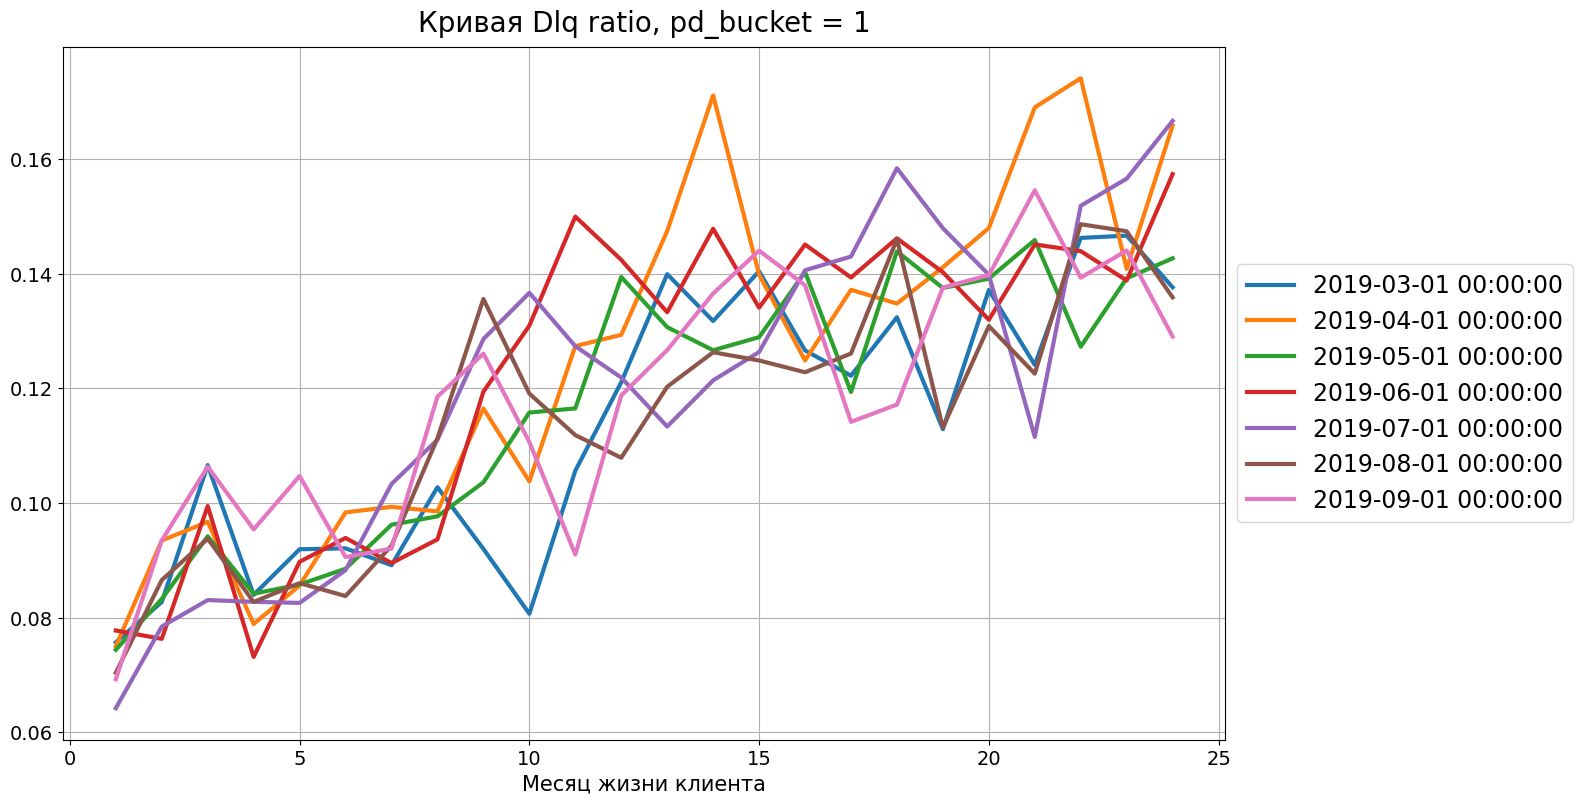

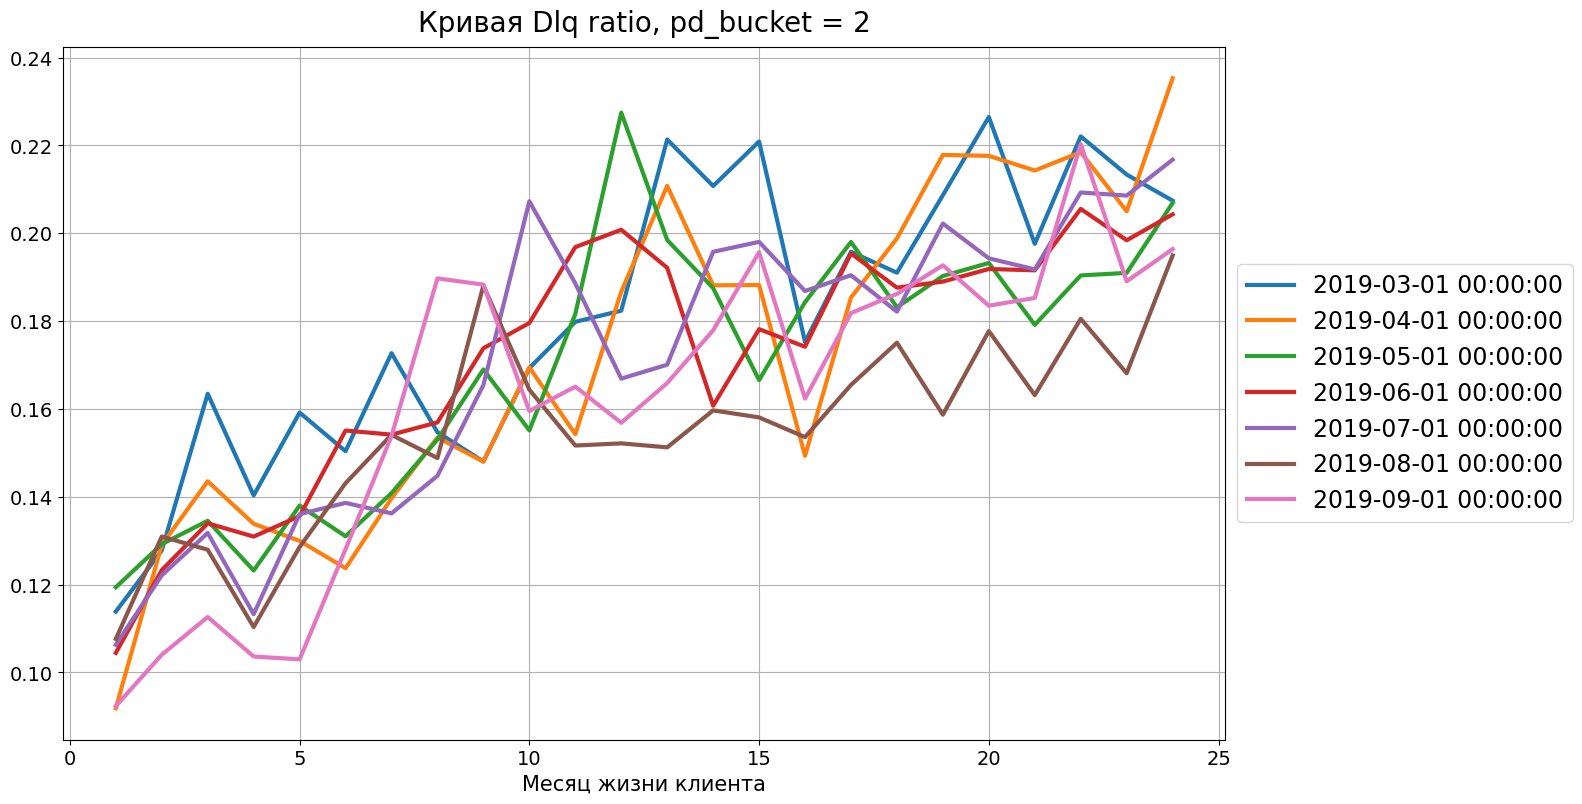

In [11]:
# Исключаем плохое поколение

df = df.loc[df["gen_month_dt"] != "2019-02-01"]

# Делаем список бакетов

buckets = df["pd_bucket"].unique()


# Строим график, который зависит от бакета


def plot_dlq_ratio_by_generation(data, pd_bucket):
    (
        data.query(""" pd_bucket == @pd_bucket""")
        .groupby(["gen_month_dt", "statement_num"])
        .agg({"dlq_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})
        .rename(
            columns=({"dlq_flg": "dlq_cnt", "act_flg": "act_cnt", "user_id": "cnt"})
        )
        .eval("dlq_ratio = dlq_cnt / act_cnt", inplace=False)
        .unstack("gen_month_dt")["dlq_ratio"]
        .plot(ax=None, figsize=(15, 9), grid=True, lw=3)
    )
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
    plt.title(
        "Кривая Dlq ratio, pd_bucket = " + str(pd_bucket),
        size=20,
        verticalalignment="bottom",
    )
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis="both", which="major", labelsize=14)


for i in sorted(buckets):
    plot_dlq_ratio_by_generation(df, i)


## Вычищение макроэкономических воздействий

Видим, что в винтажах dlq ratio присутсвуют внешние воздействия. Вычистим их с помощью разложения винтажей на две матрицы.

##### Напомним идею разложения.

Сделаем обозначения:

$t$  - календарное время;

$n$  - номер поколения;

$(t−n)$  - месяц жизни клиента;


$D(t,n)$  - значения исследуемой кривой (Delinquency ratio) в месяц  $t$  для поколения номер  $n$ ;

$E(t)$  - внешние воздействия, которые зависят только от календарного времени  $t$ ;

$M(t−n)$  - кривая созревания, которая зависит только от месяца жизни клиента  $(t−n)$ .


Будем предполагать, что в идеальном случае существует разложение
$$D(n,t)=E(t)M(t−n)$$
 

Для поиска данного разложения будем минимизировать функционал
$$ F(E,M)=\sum_{n,t}{(D(t,n)−E(t)M(t−n))}^2 \to \min_{E,M} $$
 
где  $E={E(t),t>0}$, $M={M(t−n),t−n>0}$

#### Функции, которые реализуют разложение матрицы

In [12]:
def curve_build(data, feature, generation="generation_quart",
                statement_num="statement_num", group_label="1", stable_from=6):

    df_query = data.sort_values([generation, statement_num]).reset_index(drop=True)

    generation_min = df_query[generation].min()

    values = df_query[feature].to_numpy(dtype=float)
    st_nums = (df_query[statement_num].to_numpy(dtype=int) - 1)   # возраст a=0..A-1

    # календарный индекс t=0..T-1 для каждой строки
    dates = (
        df_query[generation].dt.year * 12 + df_query[generation].dt.month
        - (generation_min.year * 12 + generation_min.month)
        + df_query[statement_num].to_numpy(dtype=int) - 1
    ).to_numpy(dtype=int)

    A = int(st_nums.max() + 1)          # длина M(a)
    T = int(dates.max() + 1)            # длина E(t)
    tab_size = len(df_query)

    stable_mask = (np.arange(T) >= stable_from)  # t>=6

    def unpack_x(x):
        E_raw = x[:T]
        M_raw = x[T:T+A]

        # среднее только по "стабильному" окну
        if stable_mask.any():
            mean_E = E_raw[stable_mask].mean()
        else:
            mean_E = E_raw.mean()

        if mean_E == 0:
            mean_E = 1e-12

        # теперь mean(E[stable_mask]) == 1
        E = E_raw / mean_E

        # сохраняем инвариантность произведения E*M
        M = M_raw * mean_E
        return E, M

    def r_square(x):
        E, M = unpack_x(x)
        pred = E[dates] * M[st_nums]
        return np.sum((values - pred) ** 2)

    x0 = np.ones(T + A, dtype=float)

    res0 = minimize(
        r_square,
        x0,
        tol=1e-6,
        method="Powell",
        options={"disp": False, "maxiter": 1000},
    )

    # достаем уже нормированные E и M
    E_hat, M_hat = unpack_x(res0.x)

    external_data = pd.DataFrame({
        "month_dt": [generation_min + pd.DateOffset(months=i) for i in range(T)],
        group_label: E_hat
    })

    maturation_data = pd.DataFrame({
        "statement_num": np.arange(1, A + 1),
        group_label: M_hat
    })

    # fitted: D / E (если хотите "очистить" от макро)
    df_query = df_query.copy()
    df_query["month_dt"] = pd.to_datetime(df_query["month_dt"], errors="coerce")
    external_data["month_dt"] = pd.to_datetime(external_data["month_dt"], errors="coerce")

    df_fitted = df_query.merge(external_data, on="month_dt", how="left")
    df_fitted["fitted_feature"] = df_fitted[feature] / df_fitted[group_label]

    return {
        "res0": res0,
        "external_data": external_data,
        "maturation_data": maturation_data,
        "df_fitted": df_fitted,
    }

def decomposition(
    df,
    generation="generation_month",
    group="bucket",
    statement_num="statement_num",
    feature="feature",
    optimization_query="",
):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == "":
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x - 1))
    df_query["month_dt"] = df_query[generation] + timedelta

    # Формируем список бакетов

    df_query.sort_values(by=[group], inplace=True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + " = " + str(g))

        # Строим разложение для одного бакета
        res = curve_build(
            df_temp,
            feature=feature,
            generation=generation,
            statement_num=statement_num,
            group_label=str(g),
        )
        df_fitted_temp = pd.DataFrame(res["df_fitted"])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res["external_data"])[["month_dt", str(g)]]
            maturation_data = pd.DataFrame(res["maturation_data"])[
                [statement_num, str(g)]
            ]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(
                right=res["external_data"], on=["month_dt"]
            )
            maturation_data = maturation_data.merge(
                right=res["maturation_data"], on=[statement_num]
            )
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i += 1

    # print(res)

    res_multiple = {
        "external_data": external_data,
        "maturation_data": maturation_data,
        "fitted_data": df_fitted,
    }
    return res_multiple

#### Применим функцию к нашим данным

In [13]:
# Подготавливаем данные
df_ratio = (
    df.groupby(["pd_bucket", "gen_month_dt", "statement_num"], as_index=False)
    .agg({"dlq_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})
    .rename(columns=({"dlq_flg": "dlq_cnt", "act_flg": "act_cnt", "user_id": "cnt"}))
    .eval("dlq_ratio = dlq_cnt / act_cnt", inplace=False)
)


# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых
res = decomposition(
    df_ratio,
    generation="gen_month_dt",
    group="pd_bucket",
    statement_num="statement_num",
    feature="dlq_ratio",
)

/var/folders/9m/694f26q91vv91hqgk616c7w80000gn/T/ipykernel_51646/2580818573.py:122: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query["month_dt"] = df_query[generation] + timedelta


pd_bucket = 0
pd_bucket = 1
pd_bucket = 2


In [14]:
# Проверяем, что действительно нормировали внешку
stable_from = 6

E = res['external_data'][['0', '1', '2']].to_numpy()
t = np.arange(len(E))
mask = t >= stable_from

mean_stable = E[mask].mean()

print("Mean(E):", mean_stable)


Mean(E): 1.0


#### Получившиеся кривые внешних воздействий

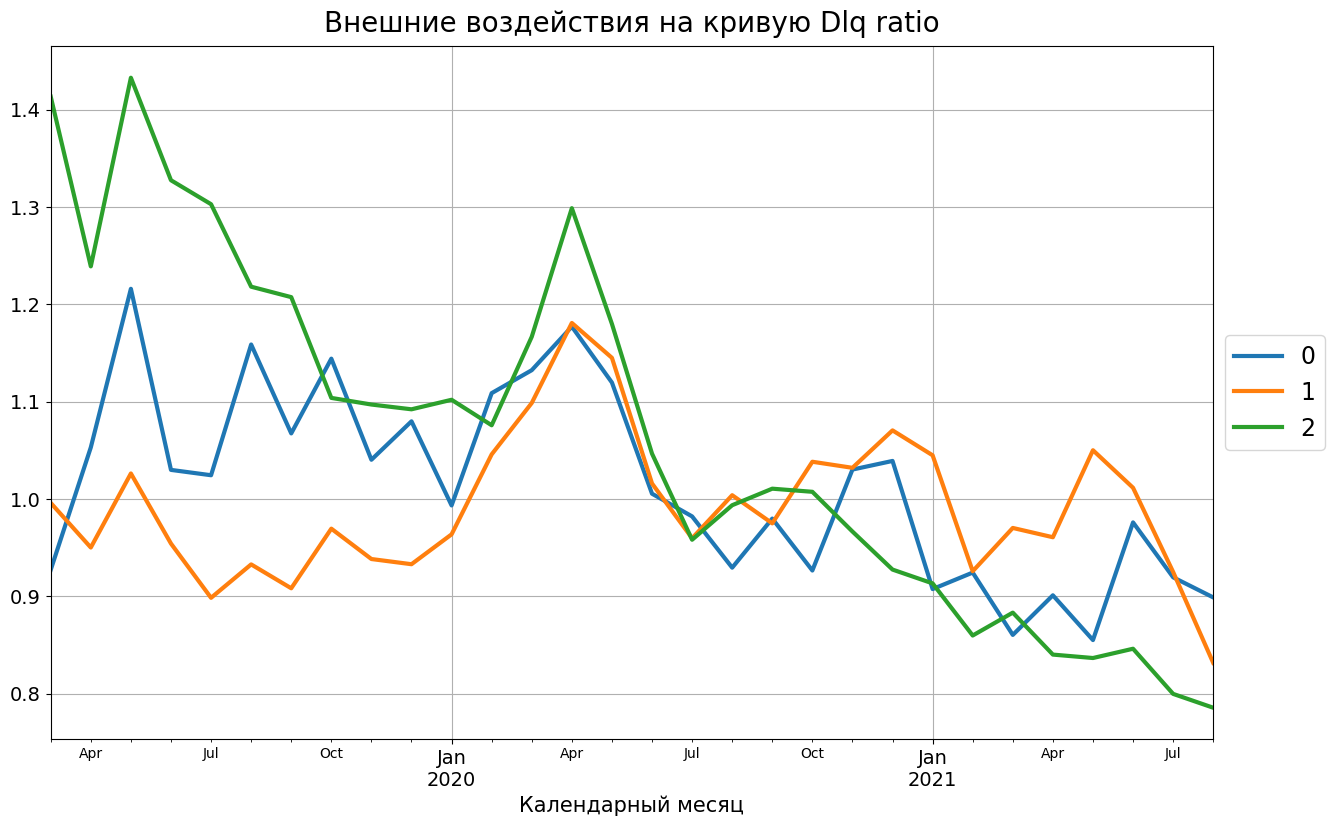

In [15]:
res["external_data"].set_index("month_dt").plot(
    ax=None, figsize=(15, 9), grid=True, lw=3
)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title(
    "Внешние воздействия на кривую Dlq ratio", size=20, verticalalignment="bottom"
)

plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

#### Кривые DLQ ratio, вычищенные от внешних воздействий

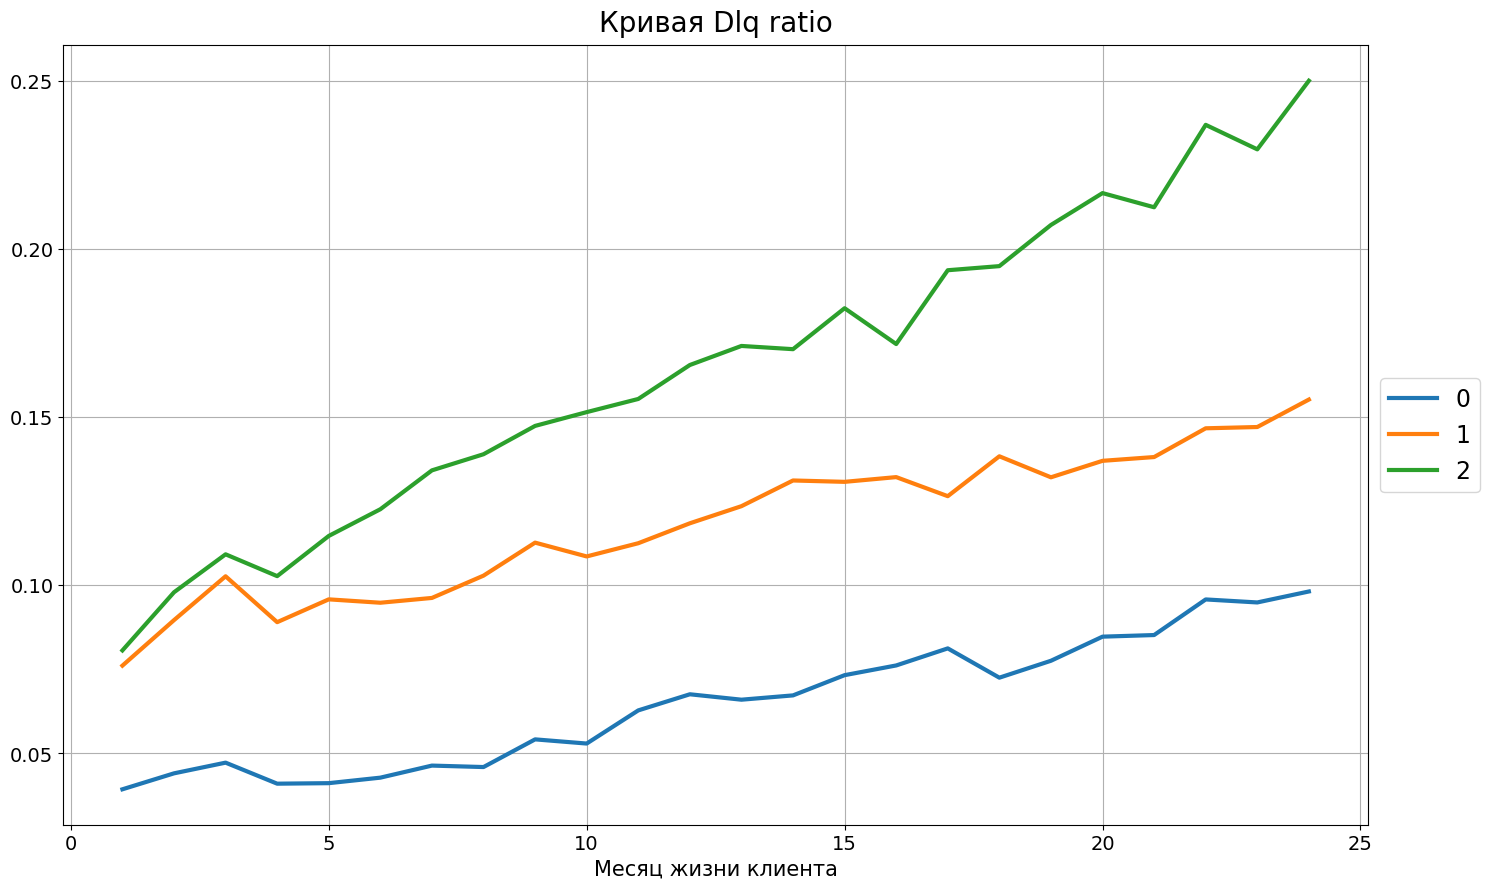

In [16]:
# Построение графика кривой Dlq ratio
ax = (
    res["maturation_data"]
    .set_index("statement_num")
    .plot(figsize=(15, 9), grid=True, lw=3)
)

# Настройка легенды
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")

# Добавление заголовка и меток осей
plt.title("Кривая Dlq ratio", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)

# Настройка подписей осей
plt.tick_params(axis="both", which="major", labelsize=14)

# Отображение графика
plt.tight_layout()
plt.show()

#### Вычищенные кривые в разбивке по поколениям

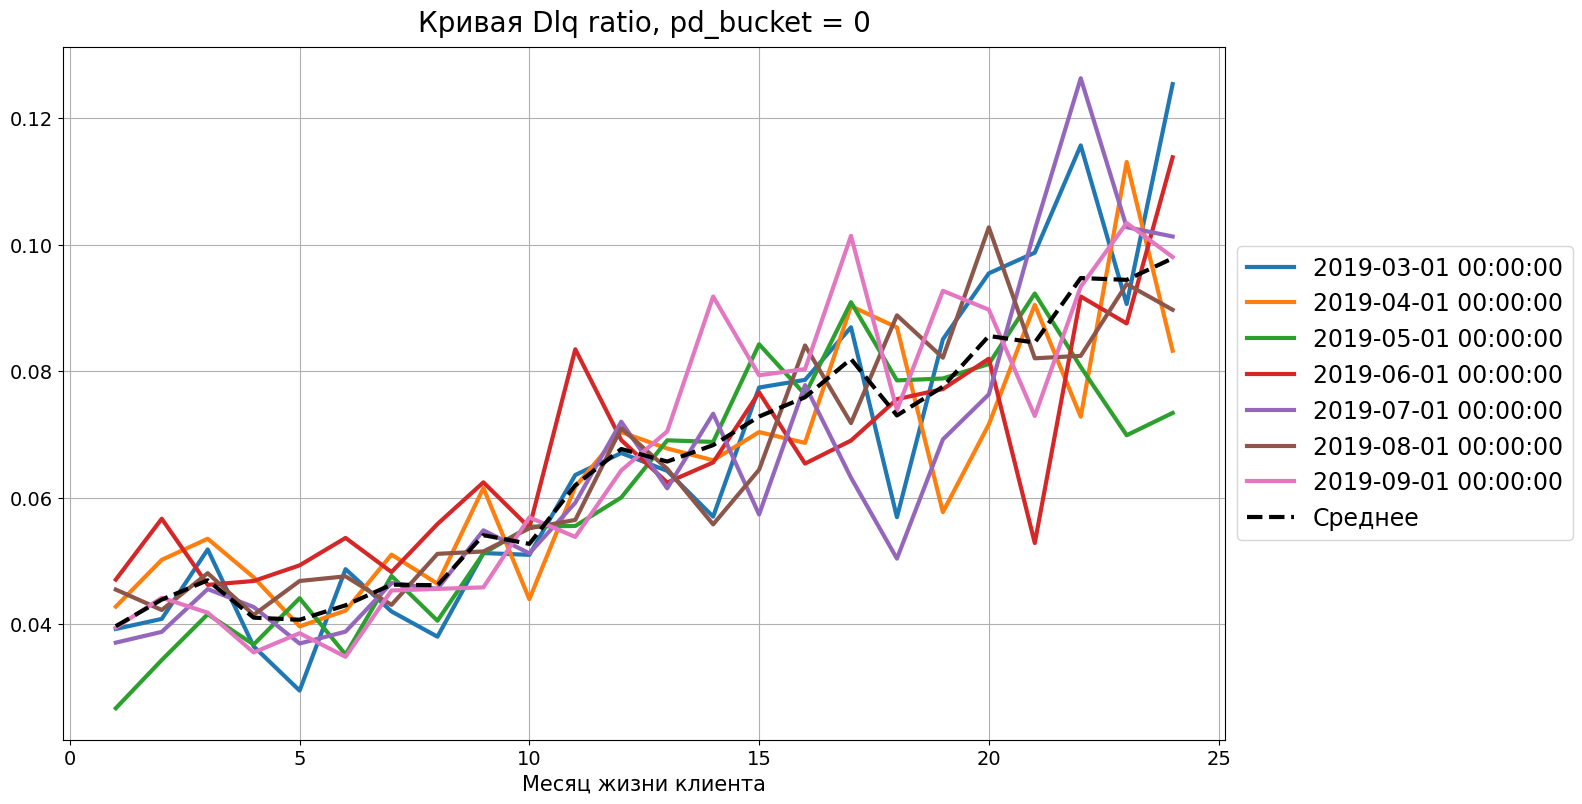

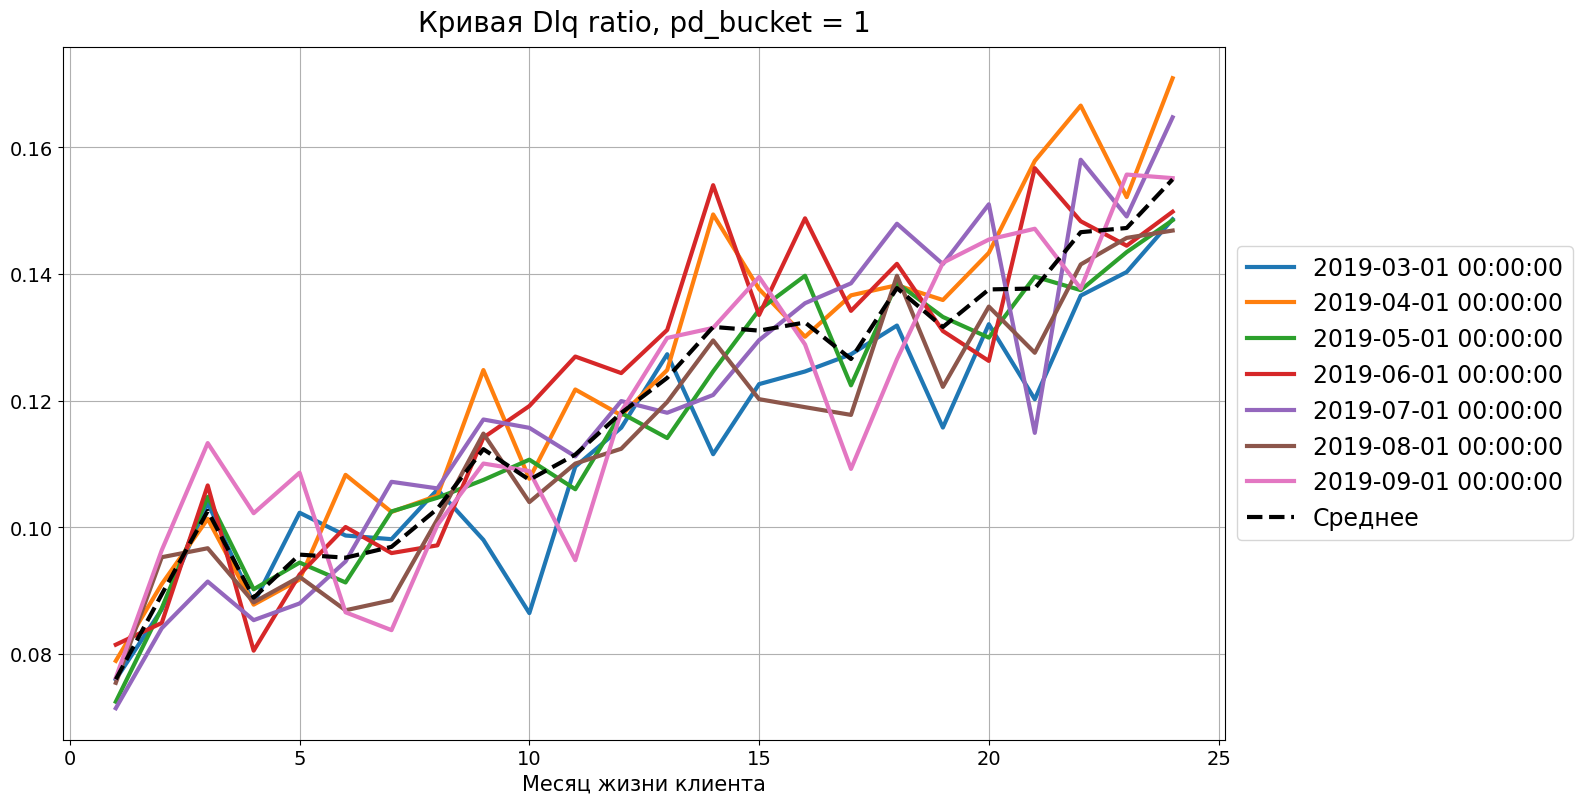

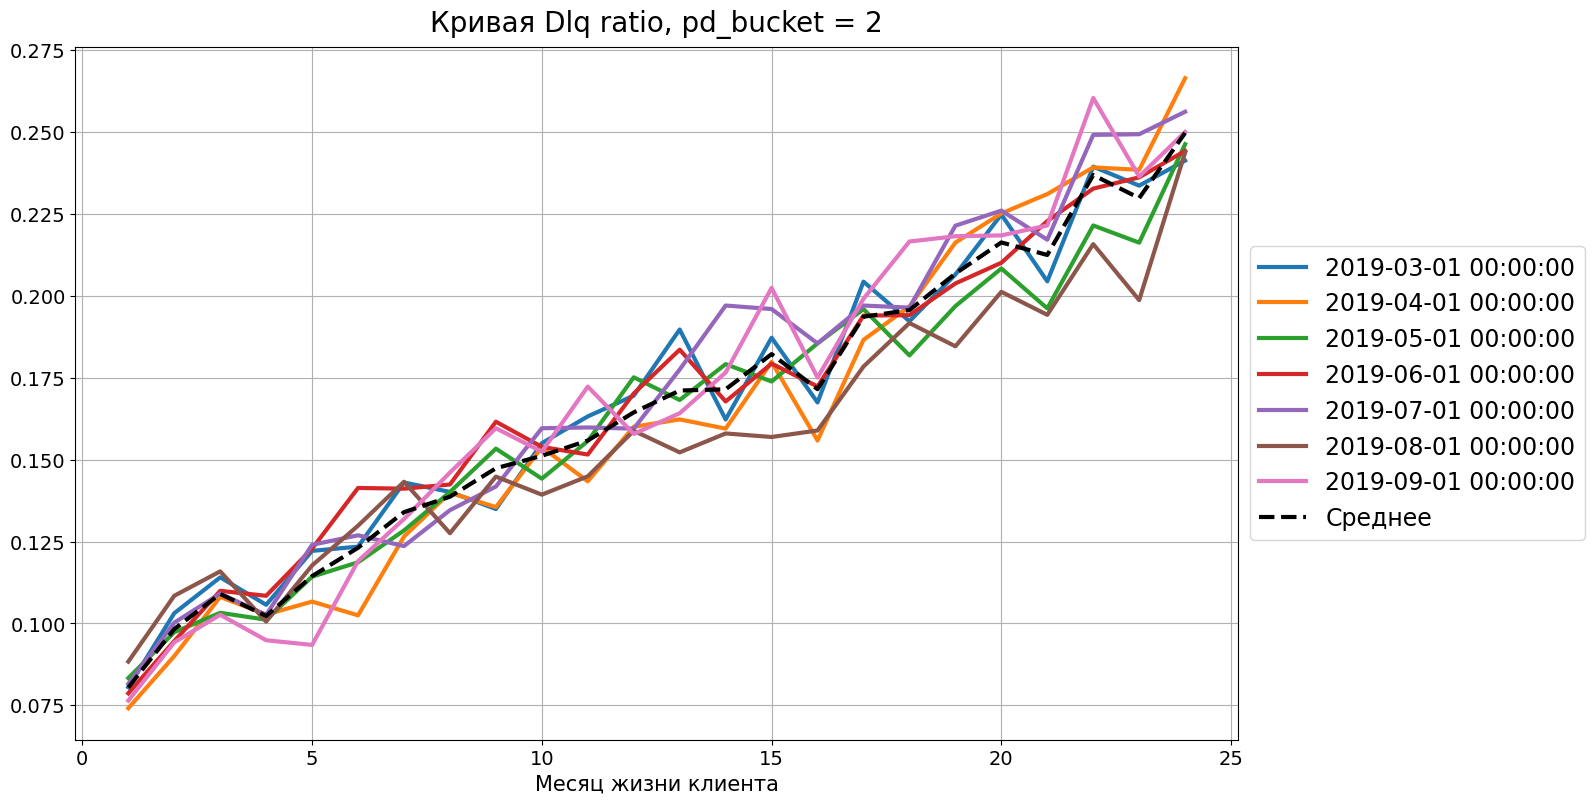

In [17]:
# Считаем среднее

dlq_ratio_mean = (
    res["fitted_data"]
    .groupby(["pd_bucket", "statement_num"])
    .agg({"fitted_feature": np.mean})
    .rename(columns={"fitted_feature": "Среднее"})
)

buckets = df["pd_bucket"].drop_duplicates()

# Строим графики винтажей и среднего


def plot_dlq_ratio_mean(pd_bucket):
    (
        res["fitted_data"]
        .query("pd_bucket == " + str(pd_bucket))
        .groupby(["gen_month_dt", "statement_num"])
        .agg({"fitted_feature": np.sum})
        .unstack("gen_month_dt")["fitted_feature"]
        .plot(ax=None, figsize=(15, 9), grid=True, lw=3)
    )  # график винтажей

    dlq_ratio_mean.loc[pd_bucket, "Среднее"].plot(
        figsize=(15, 9), grid=True, lw=3, color="Black", ls="dashed"
    )

    plt.legend(
        loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17"
    )  # чтобы отобразить их вместе
    plt.title(
        f"Кривая Dlq ratio, pd_bucket = {pd_bucket}",
        size=20,
        verticalalignment="bottom",
    )
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis="both", which="major", labelsize=14)


for i in sorted(buckets):
    plot_dlq_ratio_mean(i)

### Найдем лучшую функцию для сглаживания кривых

In [18]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res["Линейная функция"] = df["Среднее"]  # Копируем средние значения
    linear_coeff = np.polyfit(
        np.arange(start, finish + 1), df.loc[start:finish, "Среднее"], 1
    )  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)  # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, "Линейная функция"] = linear_coeff(
        np.arange(start, finish + 1)
    )  # Записываем приближение
    df_res.loc[finish + 1 :, "Линейная функция"] = linear_coeff(
        finish + 1
    )  # Продолжаем кривую константой
    return df_res


def polynom_approximation(df, start=1, finish=20, degree=1):
    df_res = pd.DataFrame(df)
    df_res["Полином"] = df["Среднее"]
    linear_coeff = np.polyfit(
        np.arange(start, finish + 1), df.loc[start:finish, "Среднее"], degree
    )  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, "Полином"] = linear_coeff(np.arange(start, finish + 1))
    df_res.loc[finish + 1 :, "Полином"] = linear_coeff(finish + 1)
    return df_res


def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [
        df_res.loc[i, "Среднее"] for i in np.arange(1, start + 1)
    ]  # Начальные значения копируем
    for n in range(start, len(df_res["Среднее"])):
        result.append(
            float(alpha * df_res.loc[n + 1, "Среднее"] + (1 - alpha) * result[n - 1])
        )  # Делаем сглаживание
    df_res["Скользящее среднее"] = result
    return df_res

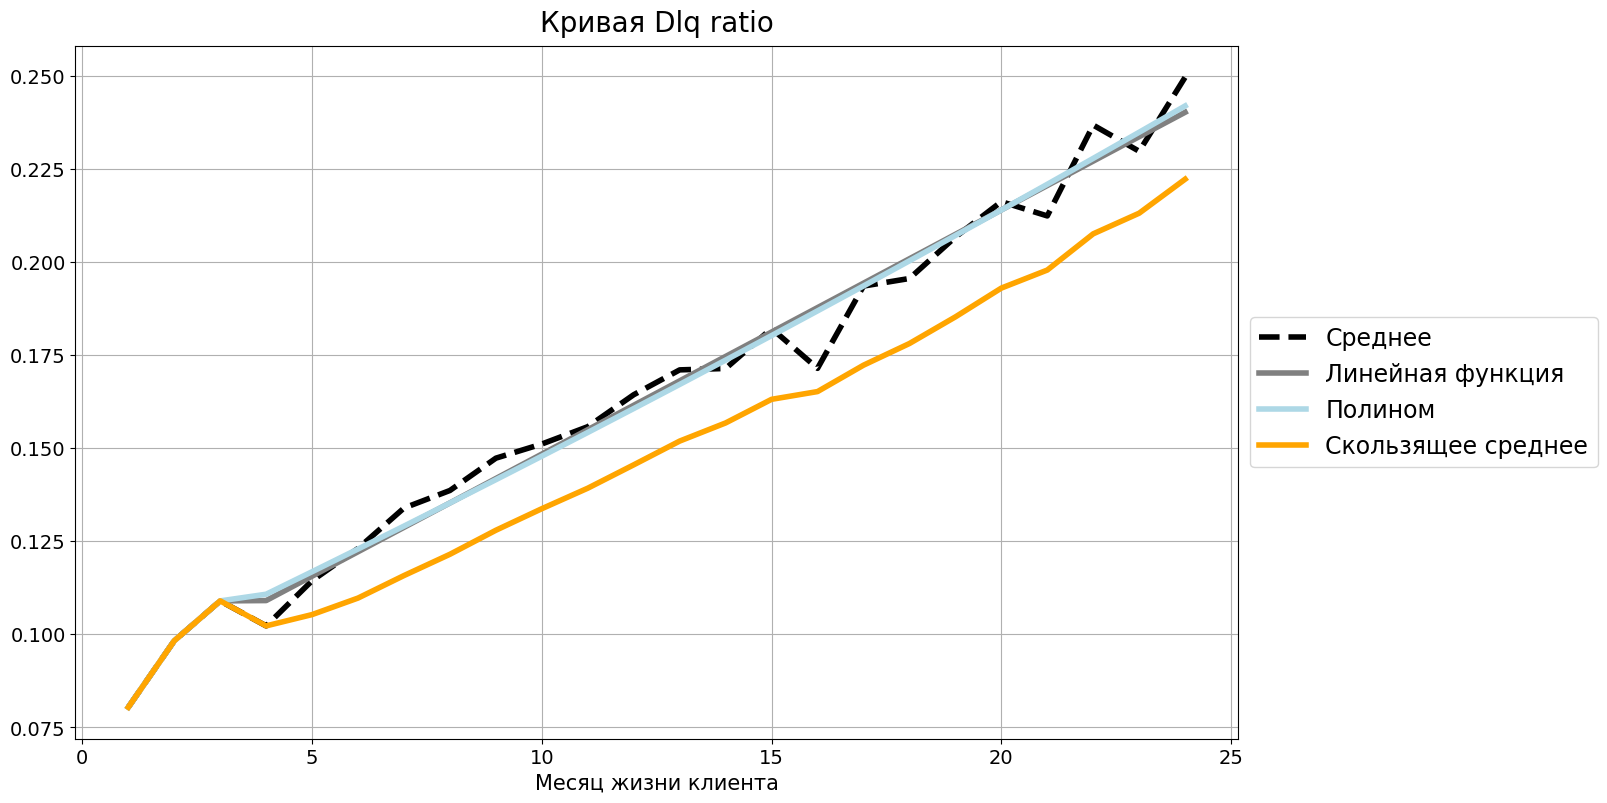

In [19]:
df_linear = (
    dlq_ratio_mean.query("pd_bucket == 2").reset_index().set_index(["statement_num"])
)
df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4, 24, 2)
df_smooth = exponential_smoothing(df_polynom, 4, 24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth["Среднее"].plot(grid=True, color="Black", linestyle="--", lw=4)
df_smooth["Линейная функция"].plot(grid=True, color="Gray", linestyle="-", lw=4)
df_smooth["Полином"].plot(grid=True, color="LightBlue", linestyle="-", lw=4)
df_smooth["Скользящее среднее"].plot(grid=True, color="Orange", linestyle="-", lw=4)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривая Dlq ratio", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

#### Для приближения воспользуемся полиномом и сгладим все кривые

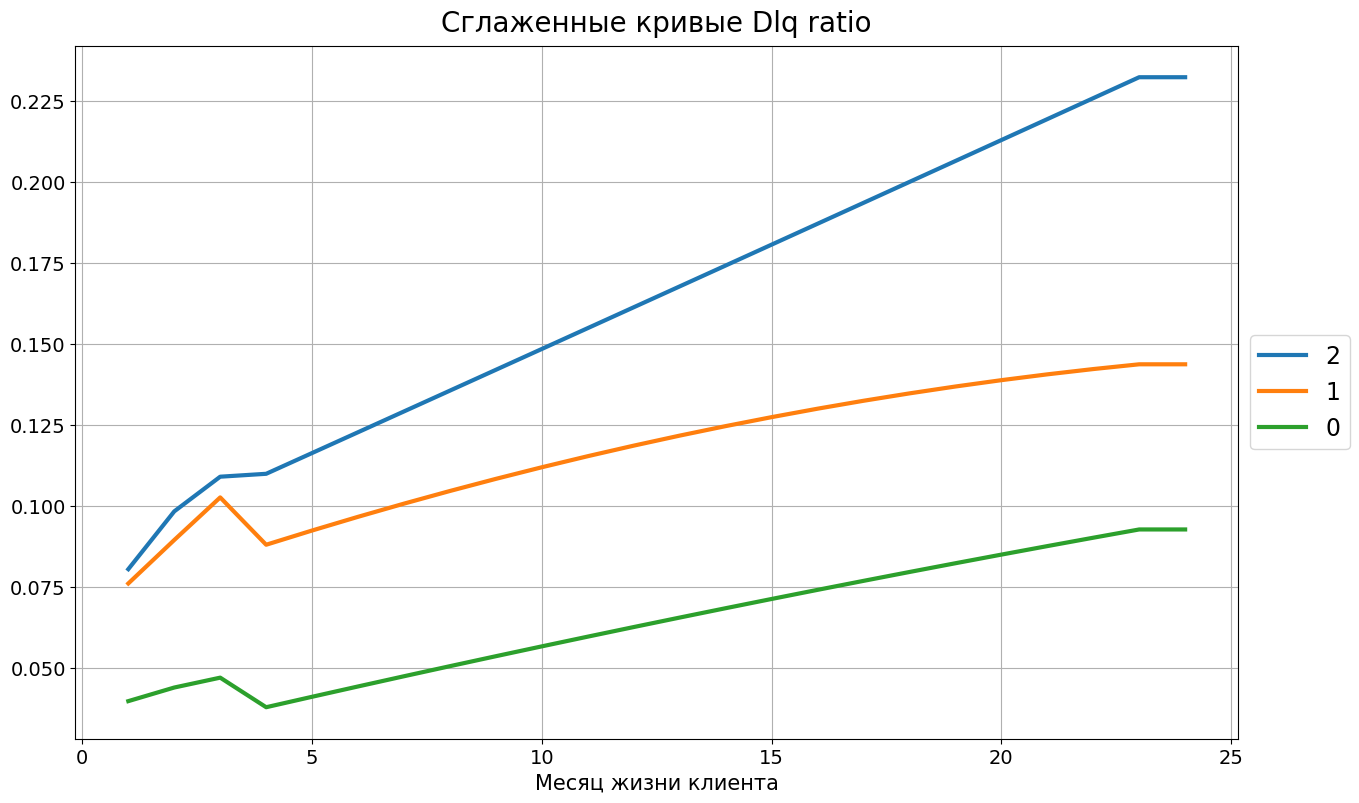

In [20]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in sorted(buckets, reverse=True):
    df_temp = (
        dlq_ratio_mean.query("pd_bucket == " + str(bucket))
        .reset_index()
        .set_index(["statement_num"])
    )
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4, 22, 2)["Полином"]

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw=3)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Сглаженные кривые Dlq ratio", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

In [21]:
df_smooth_result.to_csv("dlq_ratio.csv")